# Team NeuralNetflix
## Milestone 3 

**Here are the steps to take:**

1. We first run Part 1 to grab all movies and keywords from TMDB API and put them into the CSV file titled: *tmdb-movies-1-to-400.csv*, *tmdb-movies-401-to-800.csv*, etc.

2. Run Part 2 to grab all the IMDB ids from the TMDB ids provided as the .csv file we generated in Step 1. Write the output into another CSV titled: *imdb-ids-1-to-400.csv*, *imdb-ids-401-to-800.csv*, etc.

3. Run Part 3 to grab features from IMDB API given IMDB ids provided as the .csv file generated in Step 2. Write the output into another CSV titles: *imdb-features-1-to-400.csv*, *imdb-features-401-to-800.csv*, etc.

4. Run part 4 to merge all the CSV files and output to a single csv file.

5. Run part 5 to clean up columns to choose the right ones for Milestone 3

6. Based on the genre correlation heatmap from Milestone 1, we combine some genres together to create 7 genre groups

7. Run part 7 to perform one hot encoding of genre groups 

8. Run part 8 to split full dataset to 60% - training set(inbalanced) & 40% - testing set

9. Run part 9 to create balanced traning set

In [ ]:
# PART 1:  STANDALONE TO GRAB ALL MOVIES AND KEYWORDS

import csv
import time
import requests


#########################################################
'''
BASE STUFF THAT IS ALSO DEFINED ON TOP
'''
def requestResults(url):
    r = requests.get(BASE_URL + url + "&api_key=" + API_KEY)
    return r.json()

# Constants
BASE_URL = "https://api.themoviedb.org/3/"
API_KEY = "9767d17413ec9d9729c2cca238df02da"
GENRE_MAP = {}
for g in requestResults("genre/movie/list?x=1")[u'genres']:
    GENRE_MAP[g['id']] = g['name']
    
#########################################################


def _getKeywordsStringById(movie_id):
    
    keywords_dict = requestResults("movie/" + str(movie_id) + "/keywords?language=en-US")
    if u'keywords' not in keywords_dict:
        return ''
    keywords_dict = keywords_dict[u'keywords']
    kstring = ''
    for k in keywords_dict:
        kstring += k[u'name'] + ','
    return str(kstring.encode('utf-8').strip())[:-1]

def _tidyRow(m, keywords):
    # Makes sure the row of movie is well-formatted
    output = {}
    for k in m:
        typem = type(m[k])
        k = str(k)
        if typem == str or typem == unicode:
            output[k] = m[k].encode('utf-8').strip()
        else:
            output[k] = m[k]
    output['keywords'] = keywords
    return output

def downloadMoviesToCSV(start_page, increment, filename):
    genre_count = {}
    
    with open(filename, 'w') as csvfile:
        fieldnames = ['id', 'genre_ids', 'poster_path', 'title', 'overview', 'release_date', 
                      'popularity', 'original_title', 'backdrop_path', 'keywords', 
                     'vote_count', 'video', 'adult', 'vote_average', 'original_language']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Get keywords for movies
        writer.writeheader()
        
        # TMDB limits 4 requests per second
        hit = 3 # Once hit reaches 0, call timer and reset hit to 3
        
        for p in range(start_page,start_page+increment): 
            results_p = requestResults("discover/movie?sort_by=popularity.desc&page=" + str(p))[u'results']
            hit -= 1
            if hit <= 0:
                hit = 3
                time.sleep(1)

            # Write to CSV
            for m in results_p:
                mid = m[u'id']
                keywords = _getKeywordsStringById(mid)
                hit -= 1
                if hit <= 0:
                    hit = 3
                    time.sleep(1)
                
                row = _tidyRow(m, keywords)
                writer.writerow(row)
            print('%d pages done' % p)

In [ ]:
### Run Part 1: REMEMBER TO CHANGE start_page to your start page, don't have to change increment
downloadMoviesToCSV(start_page=1, increment=400, filename='tmdb-movies-1-to-400.csv')

In [ ]:
# PART 2: STANDALONE THAT TAKES IN .CSV FILE AND GETS ALL IMDB IDS in a separate file

import pandas as pd
import csv
import time
import requests


#########################################################
'''
BASE STUFF THAT IS ALSO DEFINED ON TOP
'''
def requestResults(url):
    r = requests.get(BASE_URL + url + "&api_key=" + API_KEY)
    return r.json()

# Constants
BASE_URL = "https://api.themoviedb.org/3/"
API_KEY = "9767d17413ec9d9729c2cca238df02da"
GENRE_MAP = {}
for g in requestResults("genre/movie/list?x=1")[u'genres']:
    GENRE_MAP[g['id']] = g['name']
    
#########################################################

def downloadIMDBIds(input_filename, output_filename):
    df = pd.read_csv(input_filename)

    with open(output_filename, 'w') as csvfile:
        fieldnames = ['id', 'imdb_id']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # TMDB limits 4 requests per second
        hit = 3 # Once hit reaches 0, call timer and reset hit to 3

        count = 0
        for tmid in df['id']:
            count += 1
            results = requestResults('movie/' + str(tmid) + '?x=1')
            if u'imdb_id' not in results or results[u'imdb_id'] is None:
                continue
            imid = results[u'imdb_id'].strip('tt')
            row = {'id': tmid, 'imdb_id': imid}
            writer.writerow(row)
            hit -= 1
            if hit <= 0:
                hit = 3
                time.sleep(1)
            if count % 200 == 0:
                print 'done with %d movies' % count

In [ ]:
### Run Part 2: Get imdb ids from tmdb ids input csv file
downloadIMDBIds(input_filename='tmdb-movies-1-to-400.csv', output_filename='imdb-ids-1-to-400.csv')

In [ ]:
# PART 3: STANDALONE THAT TAKES IN IMDB IDs and gets IMDB features
'''
Make sure you have IMDB installed.
- Go to: http://imdbpy.sourceforge.net/
- Download and unzip, then cd into it and make sure there is a setup.py file
- Run python setup.py install
- You're done! It's globally installed.
'''
import imdb
import pandas as pd
import csv
import requests
import numpy as np

def getIMDBFeatures(input_filename, output_filename, start, increment):

    # Note: This cannot be terminated via the stop button (interrupt the kernel), 
    # got to restart the kernel (use rewind button) :(
    
    ia = imdb.IMDb()
    df = pd.read_csv(input_filename)
    # Download increment movies at a time
    df = df[start:start+increment]
    
    imids = np.array(df['imdb_id'])

    with open(output_filename + '-' + str(start), 'w') as csvfile:
        # Grab these features from IMDB
        fieldnames = ['imdb_id', 'director', 'imdb_votes', 'certificate', 'num_stunts', 'num_fx']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        count = 0
        for imid in imids:
            count += 1
            # Tries twice because sometimes it fails
            for i in range(2):
                try:
                    movie = ia.get_movie(str(int(imid)))
                    director = movie['director'][0]
                    imdb_votes = movie['votes']
                    certificate = movie['certificates'][-2].split(':')[1]
                    num_stunts = len(movie['stunt performer'])
                    num_fx = len(movie['special effects department'])
                    row = {'imdb_id': imid, 'director': director, 'imdb_votes': imdb_votes, 'certificate': certificate, 
                          'num_stunts': num_stunts, 'num_fx': num_fx}
                    writer.writerow(row)
                    break
                except:    
                    pass
            if count % 100 == 0:
                print 'Done with %d movies' % count
    print 'Done with page %d' % ((start%increment) + 1)

In [ ]:
### Run Part 3: Get imdb features from imdb ids

# NOTE: This downloads 500 movies at a time and stores each in a different file.

import pandas as pd
df = pd.read_csv('imdb-ids-1001-to-1200.csv')
N = df.shape[0]
increment = 500 # Work on 500 movies at a time
end_page = N/increment

##############################################################
# NOTE: If you are done with page 2 (1000 movies), then change this to 2 the next time you start
start_page = 0
##############################################################

starts = [] 
for i in range(start_page,end_page): # default starts: [500,1000,1500,2000,2500,..,7500]
    starts.append((i+1)*increment)

for start in starts: 
    getIMDBFeatures(input_filename='imdb-ids-1-to-400.csv', output_filename='imdb-features-1-to-400.csv', 
                    start=start, increment=increment)

In [ ]:
### PART 4: Merge all and output CSV file

import pandas as pd

# NOTE: Change to your filepath and start and end movie
prefix_filepath = ''
start = 1
end = 1000

# Merge all imdb features into one
imdb_features = pd.read_csv(prefix_filepath + 'imdb-features-'+str(start)+'-to-'+str(end)+'.csv-500')
for p in range(2,8):
    imdb_features_ = pd.read_csv(prefix_filepath + 'imdb-features-'+str(start)+'-to-'+str(end)+'.csv-' + str(p*500))
    imdb_features = imdb_features.append(imdb_features_)

    
# Merge imdb ids with imdb features
imdb_ids = pd.read_csv(prefix_filepath + 'imdb-ids-'+str(start)+'-to-'+str(end)+'.csv')
imdb_ids = imdb_ids.rename(index=str, columns={"id": "tmdb_id"})
imdb_merged = imdb_ids.merge(imdb_features, how='outer', left_on='imdb_id', right_on='imdb_id')
imdb_merged = imdb_merged.dropna()

# Merge tmdb with imdb_merge
tmdb_movies = pd.read_csv(prefix_filepath + 'tmdb-movies-'+str(start)+'-to-'+str(end)+'.csv')
tmdb_movies = tmdb_movies.rename(index=str, columns={"id": "tmdb_id"})
full_movies = tmdb_movies.merge(imdb_merged, how='outer', left_on='tmdb_id', right_on='tmdb_id')
full_movies = full_movies.dropna()

# Output this to CSV of full movies
full_movies.to_csv('full-movies-'+str(start)+'-to-'+str(end)+'.csv', index=False)

In [ ]:
### PART 5: Clean up columns to choose the right ones for Milestone 3
import pandas as pd
import numpy as np
import requests

#########################################################
'''
BASE STUFF THAT IS ALSO DEFINED ON TOP
'''
def requestResults(url):
    r = requests.get(BASE_URL + url + "&api_key=" + API_KEY)
    return r.json()

# Constants
BASE_URL = "https://api.themoviedb.org/3/"
API_KEY = "9767d17413ec9d9729c2cca238df02da"
GENRE_MAP = {}
for g in requestResults("genre/movie/list?x=1")[u'genres']:
    GENRE_MAP[g['id']] = g['name']
    
#########################################################

# Merge the few tmdb-movies files together
df1 = pd.read_csv('full-movies-1-to-400.csv')
df2 = pd.read_csv('full-movies-401-to-800.csv')
df3 = pd.read_csv('full-movies-801-to-1000.csv')
df = (df1.append(df2)).append(df3)

# Choose only columns we need
cols = ['genre_ids', 'title', 'poster_path', 'tmdb_id', 'release_date', 'popularity', 'keywords', 'vote_count',
       'vote_average', 'director', 'imdb_votes', 'certificate', 'num_stunts', 'num_fx']
df = df[cols]

# Break down release date into month and year
datesplit = df['release_date'].str.split('-')
years = [int(d[0]) for d in datesplit]
months = [int(d[1]) for d in datesplit]
df['year'] = years
df['month'] = months
del df['release_date']

# Split year into decades
base = 1910
mod_var = 10
years = np.array(df['year'])
decades = (years - base) / mod_var
df['decade'] = decades
df.head()
del df['year']

# Tidy up the certificate and one-hot encoding

# Look at the certs
cert_ratings = np.unique(df['certificate'], return_counts=True)[0]
cert_counts = np.unique(df['certificate'], return_counts=True)[1]
df_cert = pd.DataFrame(columns=['name', 'count'])
df_cert['name'] = cert_ratings
df_cert['count'] = cert_counts
df_cert.sort_values('count', ascending=False)

# Relabel certs
df = df[~df['certificate'].isin(['(Banned)','10'])]
certs_formatted = []
certs = df['certificate']
for c in certs:
    if c in ['Tous publics', 'U', 'T', 'M/6', 'L', 'G', 'Btl', 'All', 'AL', 'AA', 'A', '0']: # U
        certs_formatted.append('U') 
    elif c in ['Unrated', 'Not Rated', 'H', 'B', ]: # Unrated
        certs_formatted.append('Unrated')
    elif c in ['X', 'TV-MA', 'R21', 'R(A)', 'IIB', '(Banned)', 'R']: # R
        certs_formatted.append('R')
    elif c in ['VM14', 'TV-14', 'R16', 'R-16', 'R-15', 'NC16', 
               'NC-17', 'NC-16', 'MA15+', 'M/16', 'M/14', 'M', 'K-15', 'B-15', '16', '15A', '15',
              '14', '14A']: # 15
        certs_formatted.append('15')
    elif c in ['TV-Y7', 'TV-G', 'TV-PG', 'Passed', 'PG', 'M/PG', 'K-7', 'IIA', 'GP', 'Approved', 
              '7', '8', '9', '6', '10']: # PG
        certs_formatted.append('PG')
    elif c in ['R18+', 'R18', 'R-18', 'M18', 'M/18', '18']: # 18
        certs_formatted.append('18')
    elif c in ['R13', 'R-13', 'R-12', 'PG12', 'PG13', 'PG-12', 'PG-13', 
               'P13', 'M/12', 'K-13', 'K-12', 'K-11', '13+', '13', '12A', '12+', '12', '11']: # 12
        certs_formatted.append('12')
    else: # If we miss out, which is unlikely, just mark Unrated
        print c
certs_formatted = np.array(certs_formatted)
df['certificate'] = certs_formatted

df.to_csv('full-movies-merged.csv', index=False)

In [ ]:
### PART 6: Based on the genre correlation heatmap from Milestone 1 
#to create 7 genre groups with correponding genre ids

combine_genre = {'group1': ["War","History"], 
                 'group2': ["Crime","Mystery","Thriller","Drama","Horror"], 
                 'group3': ["Fantasy"], 
                 'group4': ["Family","Animation"], 
                 'group5': ["Romance","Music"], 
                 'group6': ["Science Fiction","Action","Adventure"], 
                 'group7': ["Comedy"]}
# no western, tv movie, and documentary due to the insignificant number of movies for each genre

combine_genre_ids = {'group1': ['10752', '36'], 
                 'group2': ['80', '9648', '53', '18','27'], 
                 'group3': ['14'], 
                 'group4': ['10751','16'], 
                 'group5': ['10749', '10402'], 
                 'group6': ['878', '28', '12'], 
                 'group7': ['35']}

In [ ]:
### PART 7: One hot encoding of genre groups 

full_df = pd.read_csv("full-movies-merged.csv")

def one_hot_encoding_genre_group(df):
    num_row = len(df)
    group_df = pd.DataFrame()
    for i in range(7):
        col_name = combine_genre_ids.keys()[i]
        print(col_name)
        col_genre = combine_genre_ids.values()[i]
        #print(col_genre)
        group_df[col_name] = [0]*num_row
        for row in range(num_row):
            genres_id = df['genre_ids'][row][1:-1].split(",")
            genres_list = []
            for i in genres_id:
                genres_list.append(str(i.strip()))
            #print(genres_list)
            overlap = bool(set(genres_list) & set(col_genre))
            if overlap == True:
                #print("there is a match")
                group_df[col_name][row] = 1
        print(col_name + " done")
    return(group_df)

group_df = one_hot_encoding_genre_group(full_df)

# merge_with_group dataframe includes all the attributes in the original dataset,
# along with 7 additional binary-value columns for genre groups

merge_with_group = pd.concat([full_df, group_df], axis=1)

In [ ]:
### Part 8: Split full dataset to 60% - training set(inbalanced) & 40% - testing set

import pandas as pd
import numpy as np
import random

df = merge_with_group
counts = []
train_df = pd.DataFrame()
test_df = pd.DataFrame()

for i in range(1,8):
    sub_df = df[df['group' + str(i)] == 1]
    count = sub_df.shape[0]
    rows = random.sample(sub_df.index, int(count*0.6))
    sub_train = sub_df.ix[rows]
    sub_test = sub_df.drop(rows)
    
    train_df = pd.concat([train_df, sub_train], axis=0)
    test_df = pd.concat([test_df, sub_test], axis=0)
    
    counts.append(count)

In [ ]:
### Part 9: Run Oversampling/Undersampling algorithm to create balanced traning set

# MovieGnat Oversampling/Undersampling algorithm
df = train_df_no_dup

counts = []
# Get counts of each label
for i in range(1,8):
    count = df[df['group' + str(i)] == 1].shape[0]
    counts.append(count)

# Target number of samples to hit from oversampling and undersampling
target_count = int(np.mean(counts))

print 'Counts: \n', counts
print '\nTarget count: ', target_count

sampled_df = pd.DataFrame(columns=df.columns.values)

# Oversample the minority, and heavily undersample the majority
for l in range(1,8):
    # If above the mean, target_count is /2
    df_ = df[df['group' + str(l)] == 1]
    target_count_ = target_count/2 if df_.shape[0] > target_count else target_count
    df_sample = df_.sample(n=target_count_, replace=True)
    sampled_df = sampled_df.append(df_sample)
    
# Print out counts of each now
sampled_counts = []
for l in range(1,8):
    count = sampled_df[sampled_df['group' + str(l)] == 1].shape[0]
    sampled_counts.append(count)
sampled_counts

# Model 1

In Model 1, we use One vs Rest on the following columns:

- vote_count
- vote_average
- imdb_votes
- certificate (one-hot encoded and cleaned)
- num_stunts
- num_fx
- decade (one-hot encoded)
- month (one-hot encoded)

**We will use Radial SVM and Random Forest**

First we define our loss functions:

In [5]:
# These are how we measure error - Haming Loss, % exact matches and % at-least-one match
def error_measures(ypred, ytest):
    ypred = np.array(ypred)
    ytest = np.array(ytest)
    # Hamming loss
    from sklearn.metrics import hamming_loss
    h_loss = hamming_loss(ytest, ypred)

    # Percent exact matches
    y_pred_str = np.array([str(yi) for yi in ypred])
    y_test_str = np.array([str(yi) for yi in ytest])
    percent_exact = np.sum(y_pred_str == y_test_str) * 1. / ytest.shape[0]
    
    # Percent at least one match (at least one of the genres are both 1)
    atleastone_count = 0
    for ind in range(len(ypred)):
        yi_pred = ypred[ind]
        yi_test = ytest[ind]
        for i in range(len(yi_pred)):
            if yi_pred[i] == 1 and yi_test[i] == 1:
                atleastone_count += 1
                break
    percent_atleastone = atleastone_count * 1. / ytest.shape[0]
    
    return h_loss, percent_exact, percent_atleastone

Next we prepare the data for our model:

In [3]:
import pandas as pd
import numpy as np

# Read in the data
train = pd.read_csv('../data/train_data_with_sampling.csv')
test = pd.read_csv('../data/test_data.csv')

# Split into train and test
X_train = train[['vote_count', 'vote_average', 'imdb_votes', 'certificate', 'num_stunts', 'num_fx', 'decade', 'month']]
y_train = train[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']]
X_test = test[['vote_count', 'vote_average', 'imdb_votes', 'certificate', 'num_stunts', 'num_fx', 'decade', 'month']]
y_test = test[['group1', 'group2', 'group3', 'group4', 'group5', 'group6', 'group7']]

# One hot encoding
X_train = pd.get_dummies(data=X_train,columns = ['certificate', 'decade', 'month'])
X_test = pd.get_dummies(data=X_test,columns = ['certificate', 'decade', 'month'])

### Radial SVM

In [104]:
# Use SVM to predict multi-class
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

y_pred = OneVsRestClassifier(SVC(random_state=0)).fit(X_train, y_train).predict(X_test)

hamming_loss, percent_exact, percent_atleastone = error_measures(y_pred, y_test)
print 'Untuned Radial SVM\n=====================\n'
print 'Hamming loss: ', hamming_loss
print 'Percent exact: ', percent_exact
print 'Percent at least one: ', percent_atleastone

Untuned Radial SVM

Hamming loss:  0.0856756756757
Percent exact:  0.621621621622
Percent at least one:  0.891621621622


In [48]:
# Tune SVM

from sklearn.model_selection import KFold
from sklearn.metrics import hamming_loss

kf = KFold(n_splits=4, random_state=428)

# Use Grid Search CV
C = [0.01, 1, 10, 100]
gamma = [0.000001, 0.001, 0.1, 1]

losses = []
for Ci in C:
    for gi in gamma:
        # Cross-validate
        losses_i = []
        for train_index, test_index in kf.split(X_train):
            X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_, y_test_ = y_train.iloc[train_index], y_train.iloc[test_index]
            y_pred_ = OneVsRestClassifier(SVC(random_state=0, C=Ci, gamma=gi)).fit(
                X_train_, y_train_).predict(X_test_)
            loss = hamming_loss(y_test_, y_pred_)
            losses_i.append(loss)
        losses.append({'C': Ci, 'gamma': gi, 'cv_score': np.mean(losses_i)})

In [55]:
# Check the losses to choose the best C and gamma for Radial SVM
print 'Best performing C and gamma after tuning\n=====================\n'
best_dict = sorted(losses, key=lambda k: k['cv_score'])[0]
print best_dict
chosen_C = best_dict['C']
chosen_gamma = best_dict['gamma']

Best performing C and gamma after tuning

{'C': 10, 'cv_score': 0.12451346030757754, 'gamma': 0.1}


In [105]:
# Re-run SVM on tuned hyperparams

y_pred = OneVsRestClassifier(SVC(random_state=0, C=chosen_C, gamma=chosen_gamma)).fit(X_train, y_train).predict(X_test)

hamming_loss, percent_exact, percent_atleastone = error_measures(y_pred, y_test)
print 'Tuned Radial SVM with C=%f and gamma=%f\n=====================\n' % (chosen_C, chosen_gamma)
print 'Hamming loss: ', hamming_loss
print 'Percent exact: ', percent_exact
print 'Percent at least one: ', percent_atleastone

Tuned Radial SVM with C=10.000000 and gamma=0.100000

Hamming loss:  0.0824324324324
Percent exact:  0.630540540541
Percent at least one:  0.888108108108


After tuning our Radial SVM, percent exact went up to 63% and hamming loss went down slightly! However, it seems the percent of at least one genre matching dipped slightly.

### Random Forest

In [108]:
# Use RandomForest to predict multi-class

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=25, random_state=0)
y_pred = OneVsRestClassifier(clf).fit(X_train, y_train).predict(X_test)

hamming_loss, percent_exact, percent_atleastone = error_measures(y_pred, y_test)
print 'Untuned Random Forest\n=====================\n'
print 'Hamming loss: ', hamming_loss
print 'Percent exact: ', percent_exact
print 'Percent at least one: ', percent_atleastone

Untuned Random Forest

Hamming loss:  0.0935135135135
Percent exact:  0.606486486486
Percent at least one:  0.947297297297


In [69]:
# Tune Random Forest

from sklearn.model_selection import KFold
from sklearn.metrics import hamming_loss

kf = KFold(n_splits=4, random_state=428)

# First we test the number of trees necessary

num_trees = np.arange(5,100,5)
tree_losses = []

for num_tree in num_trees:
    # Cross-validate
    losses_i = []
    for train_index, test_index in kf.split(X_train):
        X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_test_ = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = RandomForestClassifier(n_estimators=num_tree, n_jobs=-1, random_state=0)
        y_pred_ = OneVsRestClassifier(clf).fit(X_train_, y_train_).predict(X_test_)
        loss = hamming_loss(y_test_, y_pred_)
        losses_i.append(loss)
    tree_losses.append(np.mean(losses_i))

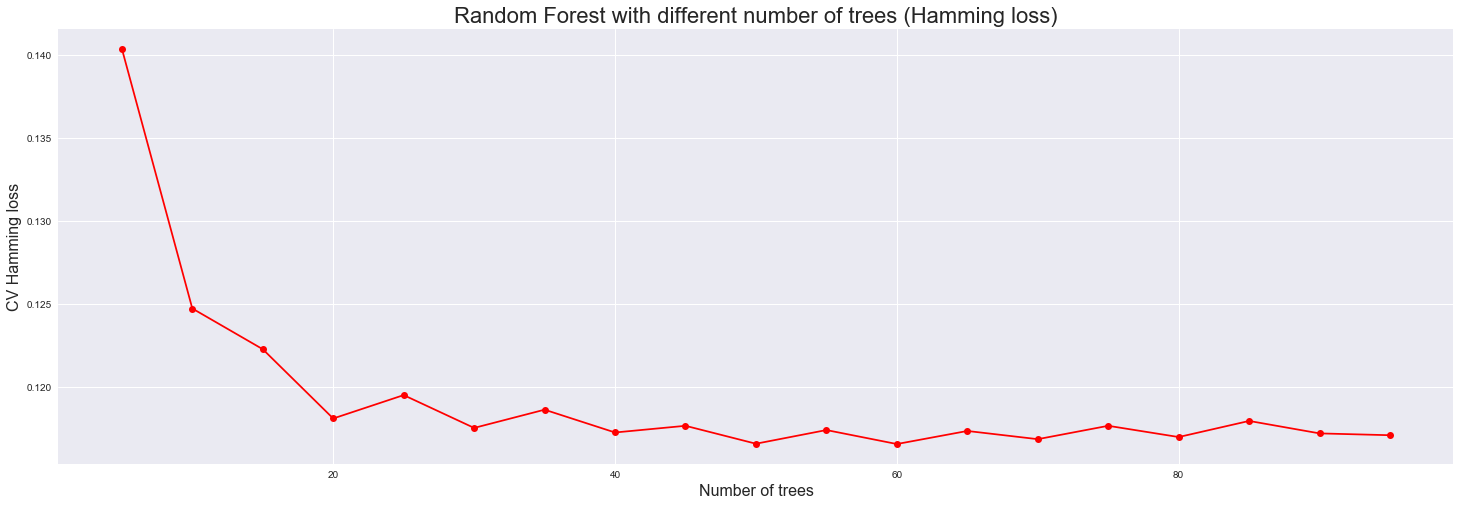

In [81]:
# We plot tree_losses, and find the lowest number of trees necessary

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# plt.plot(tree_losses)
plt.figure(figsize=(25,8))
plt.title('Random Forest with different number of trees (Hamming loss)', fontsize=22)
plt.plot(num_trees, tree_losses, 'ro-')
plt.xlabel('Number of trees', fontsize=16)
plt.ylabel('CV Hamming loss', fontsize=16)

It seems like 25 trees is more than sufficient.

In [91]:
# Tune the rest 

from sklearn.model_selection import KFold
from sklearn.metrics import hamming_loss

kf = KFold(n_splits=4, random_state=428)

num_tree_optimal = 25
max_features = ["sqrt", 0.2, 0.5, "log2", "auto"]
min_sample_leaves = [1,2,5,10,20]

losses_rf = []

for max_feature in max_features:
    for min_sample_leaf in min_sample_leaves:
        # Cross-validate
        losses_i = []
        for train_index, test_index in kf.split(X_train):
            X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_, y_test_ = y_train.iloc[train_index], y_train.iloc[test_index]
            clf = RandomForestClassifier(n_estimators=num_tree_optimal, random_state=0, n_jobs=-1,
                                        min_samples_leaf=min_sample_leaf, max_features=max_feature)
            y_pred_ = OneVsRestClassifier(clf).fit(X_train_, y_train_).predict(X_test_)
            loss = hamming_loss(y_test_, y_pred_)
            losses_i.append(loss)
        losses_rf.append({'Max_feature': max_feature, 'Min_sample_leaf': min_sample_leaf, 
                          'Loss': np.mean(losses_i)})

In [92]:
# Check the losses to choose the best max_features and min_samples_leaf for RF
print 'Best performing RF hyperparams after tuning\n=====================\n'
best_dict = sorted(losses_rf, key=lambda k: k['Loss'])[0]
print best_dict
max_feature_optimal = best_dict['Max_feature']
min_sample_optimal = best_dict['Min_sample_leaf']

Best performing RF hyperparams after tuning

{'Loss': 0.11952204859227675, 'Min_sample_leaf': 1, 'Max_feature': 'sqrt'}


In [107]:
# Re-run RF on tuned hyperparams

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=0, min_samples_leaf=min_sample_optimal,
                            max_features=max_feature_optimal)
y_pred = OneVsRestClassifier(clf).fit(X_train, y_train).predict(X_test)

hamming_loss, percent_exact, percent_atleastone = error_measures(y_pred, y_test)
print 'Tuned Random Forest\n=====================\n'
print 'Hamming loss: ', hamming_loss
print 'Percent exact: ', percent_exact
print 'Percent at least one: ', percent_atleastone

Tuned Random Forest

Hamming loss:  0.0888803088803
Percent exact:  0.615135135135
Percent at least one:  0.953783783784


After tuning, all error measures improved. **It is interesting to note that SVM is better at predicting exact matches (higher percent exact), while RF is superior in predicting percent at least one.**

### Artificial Neural Networks

In [5]:
# Let's see if we can use deep learning (ANN) for multi-label to bring error down

# Scale features first - This is particularly important for ANN
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Hand tuned the following parameters below

# Build ANN
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Initialize ANN
classifier = Sequential()

# Input layer and first hidden layer
n_in = X_train_scaled.shape[1]
n_out = y_train.shape[1] # Multi-label
n_hidden = (n_in + n_out)/2 # In + Out / 2 is a bit of an art

# Just one hidden layer is enough due to pretty simple dataset
classifier.add(Dense(units=n_hidden, kernel_initializer='uniform', activation='relu', input_dim=n_in))

# Output layer
classifier.add(Dense(units=n_out, kernel_initializer='uniform', activation='sigmoid'))

# Compile and fit ANN: Adam SGD, Log loss because of sigmoid function
classifier.compile(optimizer='adam', loss='categorical_crossentropy')
classifier.fit(X_train_scaled, y_train, batch_size=5, epochs=2) # Very small batch size for SGD


Epoch 1/2
7814/7814 [==============================] - 4s - loss: 4.7655     
Epoch 2/2
7814/7814 [==============================] - 5s - loss: 4.6060     


In [10]:
y_train

array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  1.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 0.,  1.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [6]:
# Predict after casting probabilities to labels
y_pred_proba = classifier.predict(X_test_scaled)
y_pred = []
for yi in y_pred_proba:
    yi_new = np.array([1 if yii >= 0.5 else 0 for yii in yi])
    y_pred.append(yi_new)
y_pred = np.array(y_pred)

# Use same error measures
hamming_loss, percent_exact, percent_atleastone = error_measures(y_pred, y_test)
print 'Hamming loss: ', hamming_loss
print 'Percent exact: ', percent_exact
print 'Percent at least one: ', percent_atleastone

NameError: name 'error_measures' is not defined

From a hand-tuned ANN, we can see a sharp decline in performance based on Hamming loss or percent exact. However, we see better performance for percent at least one! 

In [ ]:
# Model 2: 
# director, keywords (choose subset of keywords, then random forest on just keywords vs genre)

# Model 3: 
# posters pc scores

# Compare models using hamming loss
# Run anova?